# Web scraping

En este proyecto, vamos a recolectar, procesar y visualizar datos desde una página web real. Tienes la libertad de elegir el sitio web que más te interese (siempre que sea apto para scraping básico), o utilizar la propuesta sugerida.

### ¿Qué sitio web puedes usar?

**Opción A:** Sitio web de tu elección

Puedes elegir cualquier página que contenga datos visibles en el HTML y que sean de tu interes.

> 💡 **IMPORTANTE:** Para que la practica pueda ser llevada a cabo de una forma viable, ten en cuenta lo siguiente:

- Los datos deben ser visibles al ver el código fuente (clic derecho → "Ver código fuente").

- El sitio no debe requerir inicio de sesión ni usar JavaScript para cargar el contenido.

- La estructura debe ser simple y repetitiva (tablas o listas).

**Opción B:** Propuesta sugerida – Wikipedia: Canciones más reproducidas en Spotify 🎧

Si prefieres no buscar un sitio por tu cuenta, puedes usar esta tabla de Wikipedia: [Canciones más reproducidas en Spotify](https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify)

Contiene información sobre:

- Título de la canción

- Artista

- Reproducciones

- Año de lanzamiento

Es una excelente opción para practicar scraping con tablas.

## Paso 1: Instalación de dependencias

Asegúrate de que tienes instalados los paquetes `pandas` y `requests` de Python para poder trabajar en el proyecto. En el caso de que no tengas las librerías instaladas, ejecuta en la consola:

```bash
pip install pandas requests lxml
```

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt



## Paso 2: Descargar HTML

La descarga del HTML de la página web se realizará con la librería `requests`, como vimos en la teoría del módulo.

In [2]:
URL = "https://books.toscrape.com/"
header = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
          ' AppleWebKit/537.36 (KHTML, like Gecko) Chrome/141.0.0.0 Safari/537.36'}

# Hacer la petición a la url indicada
response = requests.get(URL, headers = header, timeout = 3)

## Paso 3: Transforma el HTML


Con `BeautifulSoup`, analizá el HTML para encontrar la estructura que contiene los datos (por ejemplo: `<table>`, `<li>`, `<div>`, etc.).

Si usás Wikipedia y contiene una tabla, podés usar directamente `pandas.read_html()` para cargarla como DataFrame.

In [3]:
# crear el objeto `Beautifulsoup`
soup = BeautifulSoup(response.content, "html.parser")

# Examinando el documento html encuentro dentro de un div,
# un único <ul class='nav nav-list'> con <ul> anidado`y dentro
# una etiqueta <a>`que contiene las categorias que busco
# usar .find() para encontrar una unica etiqueta <ul>, el bloque principal de las categorias
nav_list = soup.find('ul', class_='nav nav-list')

#dentro encuentro 'ul' anidado
sub_list = nav_list.find('ul')

#y por último  localizo todas las <a> dentro del último <ul>
categoria = sub_list.find_all('a')

#lista final con las categorías, libros y precios
libreria = []

#recorro todas las categorias y extraigo el texto
for i in categoria:
    NOMBRE_CATEGORIA = str.strip(i.get_text())
    #completo la url relativa para cada página en 'categoria'
    url_categoria = URL + i['href']
    #peticiones a las primeras págians de las categorias
    response = requests.get(url_categoria, headers=header, timeout=2)
    soup = BeautifulSoup(response.content, "html.parser")
    #extaer libros y precios
    #<article class="product_pod">
    libros = soup.find_all('article', class_='product_pod')
    for libro in libros:
        #dentro de 'article', class_='product_pod'busco etiqueta h3-->a
        #para obtener el titulo del libro
        titulo = libro.h3.a['title']
        PRICE = str.strip(libro.find('p', class_='price_color').get_text())#strip=tTrue
        libreria.append({"Categoria":NOMBRE_CATEGORIA, "Título": titulo, "Precio": PRICE[1:]})



## Paso 4: Procesa el DataFrame

A continuación, limpia las filas para obtener los valores limpios. Elimina también aquellas que estén vacías o no tengan información.

In [4]:
#libreria
df = pd.DataFrame(libreria)
df.to_csv("libreria.csv")
df

,Categoria,Título,Precio
0,Travel,It's Only the Himalayas,45.17
1,Travel,Full Moon over Noah’s Ark: An Odyssey to Mount...,49.43
2,Travel,See America: A Celebration of Our National Par...,48.87
3,Travel,Vagabonding: An Uncommon Guide to the Art of L...,36.94
4,Travel,Under the Tuscan Sun,37.33
...,...,...,...
512,Politics,Why the Right Went Wrong: Conservatism--From G...,52.65
513,Politics,Equal Is Unfair: America's Misguided Fight Aga...,56.86
514,Cultural,Amid the Chaos,36.58
515,Erotica,Dark Notes,19.19


## Paso 5: Almacena los datos en sqlite

Crea una instancia vacía de la base de datos e incluye en ella los datos limpios, como vimos en el módulo de bases de datos. Una vez tengas una base de datos vacía:

1. Crea la tabla.
2. Inserta los valores.
3. Almacena (`commit`) los cambios.

In [ ]:
# Conectar y crear la base de datos
conn = sqlite3.connect("libreria.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE libros (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    categoria TEXT NOT NULL,
    titulo TEXT NOT NULL,
    precio REAL
)
""")

In [ ]:
# Convierto dataFrame a lista de tuplas para insertar
valores = list(df.itertuples(index=False, name=None))
#Uso execurtmany para insertar varios registros
cursor.executemany("""
INSERT INTO libros (categoria, titulo, precio)
VALUES (?, ?, ?)
""", valores)

In [6]:
#Guardo los cambios
conn.commit()
conn.close()

## Paso 6: Visualiza los datos (opcional, pero muy recomendado)

Si aún no has revisado los conceptos y prácticas de visualización, no te preocupes. Intenta hacer que esto funcione, y exploraremos la visualización en detalle en los próximos proyectos.

¿Qué tipos de visualizaciones podemos realizar? Propón al menos 3 y muéstralos.

In [ ]:
#comprobamos los tipos de datos
df.dtypes

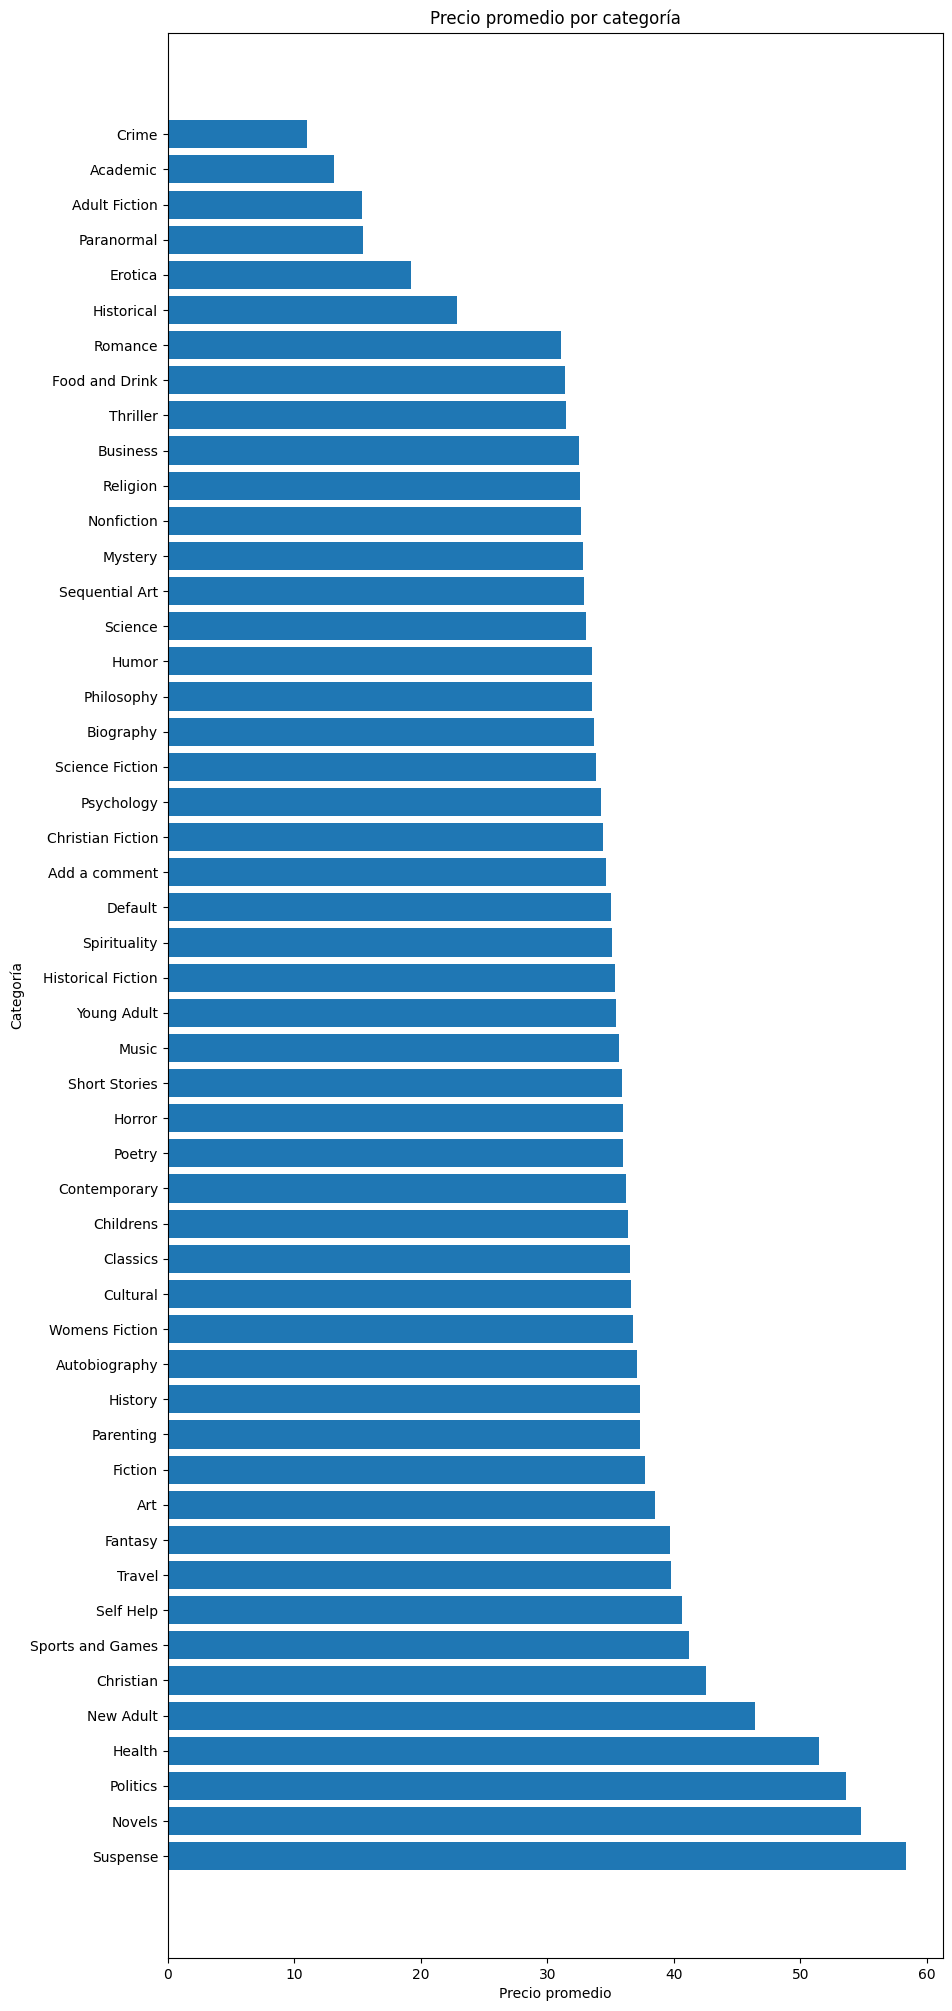

In [24]:


#convertimos columna 'precio' en dato numerico (float) dado que es de tipo object
df['Precio'] = pd.to_numeric(df['Precio'], errors='coerce')

#Media de precio  de libros por categoría 
media_precio = df.groupby('Categoria')['Precio'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,25))

# Hacer un barplot horizontal con Matplotlib
plt.barh(media_precio.index, media_precio.values)

# Títulos y etiquetas
plt.title('Precio promedio por categoría')
plt.xlabel('Precio promedio')
plt.ylabel('Categoría')

plt.show()




Dado que este gráfico ofrece muy poca legibilidad, vamos a probar otro tipo de gráfico, usaremos un boxplot para ver los precios por categoria, además usaremos solo las 10 primeras categoria más vendidas.

/tmp/ipykernel_772/3367437357.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_10_cat)


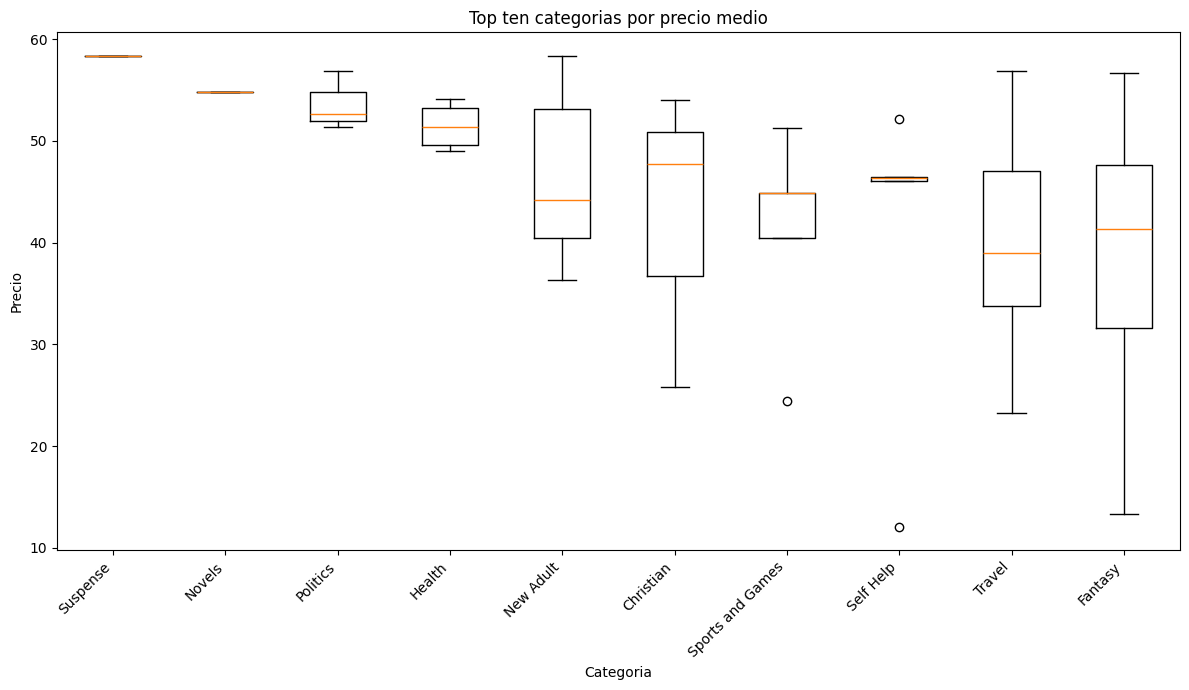

In [ ]:
media_precio = df.groupby('Categoria')['Precio'].mean().sort_values(ascending=False)

#10 categorias con mayor  precio medio
top_10_cat = media_precio.head(10).index

#filtro el df para incluir solo esas categorias
df_top_ten = df[df['Categoria'].isin(top_10_cat)].copy()

#Reordenar el DF según el orden de top_10_cat
df_top_ten['Categoria'] = pd.Categorical(df_top_ten['Categoria'], categories=top_10_cat, ordered=True)
df_top_ten = df_top_ten.sort_values('Categoria')

#Crear el gráfico
plt.figure(figsize=(12,7))

#Creo una lista de precios por categoría en orden
data = [df_top_ten.loc[df_top_ten['Categoria'] == cat, 'Precio'] for cat in top_10_cat]

plt.boxplot(data, labels=top_10_cat)



plt.title('Top ten categorias por precio medio')
plt.xlabel('Categoria')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Donde podemos ver que entre los libros más caros esta suspense, novelas y politica. Tambien podemos observar que la categoria con valores más dispares son los de autoayuda, además la categoria con un mayor rango de precios son los de fantasia.